In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## Hyper-parameters

In [12]:
data_path = '../data'

batch_size = 32

hidden_layer = 200

logging_dispfig = True
maximum_epoch = 25
learning_rate = 0.1

## MNIST data load and preprocessing

In [13]:
train_data = MNIST('./', train=True, transform=ToTensor(),
                   target_transform=None, download=True)
train_data, valid_data = random_split(train_data, [54000, 6000])
test_data = MNIST('./', train=False, transform=ToTensor(),
                  target_transform=None, download=True)

# Check the data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

===================== Check the data =========================

Train dataset length = 54000
Valid dataset length = 6000
Test dataset length = 10000



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
train_0_x, train_0_y = train_data[0]
train_0_x.shape

# train_data[53999] 까지 가능

torch.Size([1, 28, 28])

In [15]:
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')

Content of Y (Label, type=<class 'int'>) = 6
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


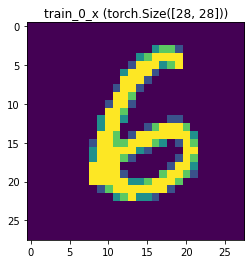

In [16]:
plt.figure(1)
plt.imshow(train_0_x.squeeze()/255.0)
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size,
                          pin_memory=True, shuffle=True, drop_last=True)
# drop_last=True 하면 마지막의 incomplete batch를 drop한다

valid_loader = DataLoader(valid_data, batch_size=len(valid_data),
                          pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data),
                         pin_memory=True)

Idx: 0 / X.shape = torch.Size([32, 1, 28, 28]) / Y.shape = torch.Size([32])

Y[0: 32] = tensor([1, 4, 8, 0, 5, 1, 6, 8, 9, 3, 7, 4, 2, 9, 7, 8, 9, 8, 9, 1, 3, 1, 8, 5,
        0, 3, 7, 1, 1, 9, 9, 6])


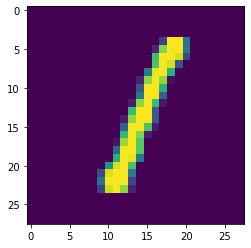

In [18]:
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)

print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0: {batch_size}] = {ex_label}')

preview_index = 0
plt.figure(2)
plt.imshow(ex_data[preview_index, 0, :, :])

## Function definitions

In [19]:
# Model
def init_model(_net):
    global net, loss_fn, optim
    net = _net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def epoch(data_loader):
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_out, last_label = None, None
    last_grad_performed = False

    # mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.view([len(_data), -1]).to(device), \
                      _label.to(device)
        
        # 1. feed-forward
        onehot_out = net(data)

        # 2. calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())  # item은 tensor dtype을 python 스칼라로 반환

        # 3. calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. backward prop if not in 'torch.no_grad()'
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True
        
        # 5. save current iteration data for future use
        last_out = out.cpu().detach()
        last_label = _label
    
    # up epoch count if backward prop is done
    if last_grad_performed:
        epoch_cnt += 1
    
    return np.average(iter_loss), np.average(iter_acc), last_out, last_label

def epoch_not_finished():
    return epoch_cnt < maximum_epoch

In [20]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
  # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
  # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## Model Architectures

In [21]:
# simple linear model (1 layer)
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(784, 10)
    
    def forward(self, x):
        return self.linear(x)

net = LinearModel()

In [22]:
# MLP model
class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
    
        self.fc1 = nn.Linear(len(train_0_x.view([-1])),
                             hidden_layer, bias=False)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer, 10, bias=False)
        
    def forward(self, x):
        out = self.fc1(x)
        hidden = self.act(out)
        onehot_out = self.fc2(hidden)

        return onehot_out

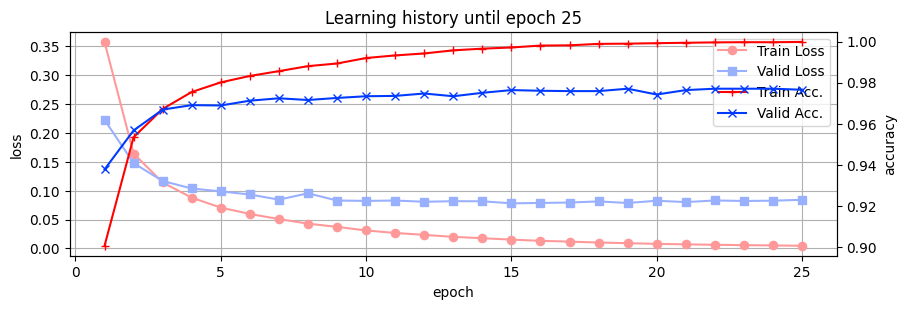

Iter:   25 >> T_loss 0.00467    T_acc 0.99980   V_loss 0.08417    V_acc 0.97650   🕒 5.228s
Iter:   24 >> T_loss 0.00527    T_acc 0.99965   V_loss 0.08267    V_acc 0.97700   🕒 5.151s
Iter:   23 >> T_loss 0.00576    T_acc 0.99967   V_loss 0.08215    V_acc 0.97700   🕒 5.175s
Iter:   22 >> T_loss 0.00639    T_acc 0.99957   V_loss 0.08306    V_acc 0.97700   🕒 5.173s
Iter:   21 >> T_loss 0.00716    T_acc 0.99939   V_loss 0.08024    V_acc 0.97633   🕒 5.184s
Iter:   20 >> T_loss 0.00795    T_acc 0.99918   V_loss 0.08260    V_acc 0.97417   🕒 5.150s
Iter:   19 >> T_loss 0.00921    T_acc 0.99896   V_loss 0.07868    V_acc 0.97700   🕒 5.129s
Iter:   18 >> T_loss 0.01027    T_acc 0.99885   V_loss 0.08143    V_acc 0.97583   🕒 5.172s
Iter:   17 >> T_loss 0.01186    T_acc 0.99815   V_loss 0.07946    V_acc 0.97583   🕒 5.140s
Iter:   16 >> T_loss 0.01324    T_acc 0.99802   V_loss 0.07876    V_acc 0.97600   🕒 5.196s
Iter:   15 >> T_loss 0.01532    T_acc 0.99709   V_loss 0.07808    V_acc 0.97633   🕒 5.164s

In [23]:
init_model(MLP1())
init_epoch()
init_log()

# training iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

# acc for test dataset
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

In [24]:
class MLPReLUBatchNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPReLUBatchNorm, self).__init__()
        
        self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        
        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        
        onehot_out = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, onehot_out
    
init_model(MLPReLUBatchNorm(len(train_0_x.view([-1])), 10).to(device))
plot_inner_dist()

NameError: ignored

## 과제

In [1]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.3 kB/s 
     |████████████████████████████████| 8.8 MB 45.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.2.0+cu92 which is incompatible.


In [10]:
import csv
import numpy as np
import pandas as pd
import torch

from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


# custom dataset
root = '/content/drive/MyDrive/과제/'

class CharDataset(Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        if self.train:
            root = root + 'train.csv'
        else:
            root = root + 'test.csv'
        self.csv = pd.read_csv(root, header=None)
        self.transform = transform
    
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, index):
        if self.train:
            label = torch.tensor(self.csv.iloc[index,0],
                                 dtype=torch.long)
            img = np.array(self.csv.iloc[index,1:]/255).reshape(28,28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, label
        
        else:
            img = np.array(self.csv.loc[index]/255).reshape(28,28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [12]:
# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## Hyper-parameters

In [13]:
batch_size = 32
hidden_layer = 300
logging_dispfig = True
maximum_epoch = 25
learning_rate = 0.001

In [14]:
train_data = CharDataset(root, train=True, transform=ToTensor())
train_data, valid_data = random_split(train_data,
                                      [round(len(train_data)*0.9),
                                       round(len(train_data)*0.1)])
test_data = CharDataset(root, train=False, transform=ToTensor())

===================== Check the data =========================

Train dataset length = 13481
Valid dataset length = 1498
Test dataset length = 3745

Content of Y (Label, type=<class 'torch.Tensor'>) = 5
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


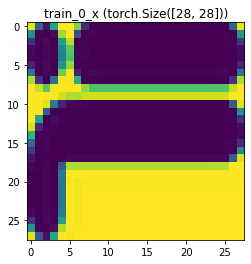

In [7]:
# check data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

In [8]:
# data loader
train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data),
                          pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data),
                         pin_memory=True)

# examine data loader
# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')
preview_index = 0

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([32, 1, 28, 28]) / Y.shape = torch.Size([32])

Y[0:32] = tensor([8, 8, 9, 0, 8, 2, 9, 0, 0, 9, 5, 4, 5, 2, 4, 7, 0, 3, 3, 5, 3, 5, 3, 7,
        8, 2, 8, 6, 2, 5, 6, 6])


## Model

In [9]:
# Model
def init_model(_net):
    global net, loss_fn, optim
    net = _net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

    
def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_out, last_label = None, None
    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.view([len(_data), -1]).to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        # 5. Save current iteration data for future use
        last_out = out.cpu().detach()
        last_label = _label

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    return np.average(iter_loss), np.average(iter_acc), last_out, last_label


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

In [10]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
  # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
  # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## MLP1

In [12]:
class MyModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyModel, self).__init__()
        
        self.hidden_layer1 = 165
        self.hidden_layer2 = 165
        self.hidden_layer3 = 165
        self.dropout_rate = .3
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(self.dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(self.dropout_rate)

        self.fc3 = nn.Linear(self.hidden_layer2, self.hidden_layer3)
        self.bn3 = nn.BatchNorm1d(self.hidden_layer3)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(self.dropout_rate)       
        
        self.fc4 = nn.Linear(self.hidden_layer3, out_features)
        
    def forward(self, x):
        hidden1 = self.act1(self.bn1(self.fc1(x)))
        drop1 = self.drop1(hidden1)
        
        hidden2 = self.act2(self.bn2(self.fc2(drop1)))
        drop2 = self.drop2(hidden2)

        hidden3 = self.act3(self.bn3(self.fc3(drop2)))
        drop3 = self.drop3(hidden3)

        onehot_out = self.fc3(drop3)
        
        return onehot_out

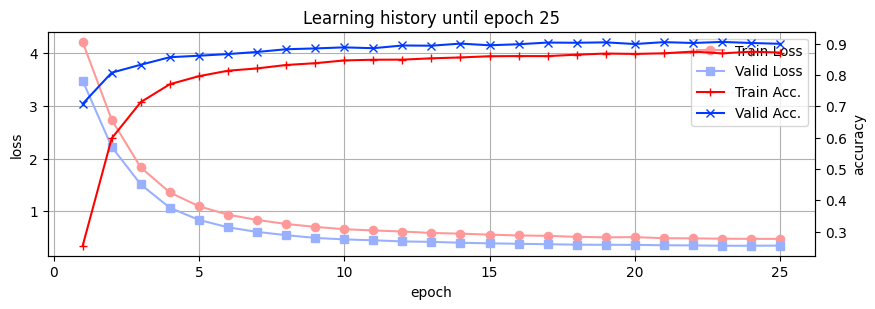

Iter:   25 >> T_loss 0.47389    T_acc 0.87203   V_loss 0.34543    V_acc 0.89987   🕒 10.658s
Iter:   24 >> T_loss 0.47370    T_acc 0.87470   V_loss 0.34311    V_acc 0.90254   🕒 10.581s
Iter:   23 >> T_loss 0.47709    T_acc 0.86936   V_loss 0.34236    V_acc 0.90587   🕒 10.727s
Iter:   22 >> T_loss 0.48358    T_acc 0.87500   V_loss 0.34975    V_acc 0.90254   🕒 10.577s
Iter:   21 >> T_loss 0.48637    T_acc 0.86958   V_loss 0.35240    V_acc 0.90521   🕒 10.674s
Iter:   20 >> T_loss 0.50742    T_acc 0.86758   V_loss 0.35949    V_acc 0.89920   🕒 10.714s
Iter:   19 >> T_loss 0.50266    T_acc 0.86884   V_loss 0.36128    V_acc 0.90454   🕒 10.664s
Iter:   18 >> T_loss 0.51265    T_acc 0.86520   V_loss 0.36303    V_acc 0.90320   🕒 10.634s
Iter:   17 >> T_loss 0.53096    T_acc 0.86060   V_loss 0.37204    V_acc 0.90387   🕒 10.674s
Iter:   16 >> T_loss 0.53917    T_acc 0.86075   V_loss 0.38021    V_acc 0.89853   🕒 10.667s
Iter:   15 >> T_loss 0.55411    T_acc 0.86023   V_loss 0.38868    V_acc 0.89519 

In [13]:
# Training Initialization
init_model(MyModel(len(train_0_x.view([-1])), 10))
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## MLP 2

In [ ]:
class MyModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyModel, self).__init__()
        
        self.hidden_layer1 = 165
        self.hidden_layer2 = 165
        self.hidden_layer3 = 165
        self.dropout_rate = .3
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(self.dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(self.dropout_rate)

        self.fc3 = nn.Linear(self.hidden_layer2, self.hidden_layer3)
        self.bn3 = nn.BatchNorm1d(self.hidden_layer3)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(self.dropout_rate)       
        
        self.fc4 = nn.Linear(self.hidden_layer3, out_features)
        
    def forward(self, x):
        hidden1 = self.act1(self.bn1(self.fc1(x)))
        drop1 = self.drop1(hidden1)
        
        hidden2 = self.act2(self.bn2(self.fc2(drop1)))
        drop2 = self.drop2(hidden2)

        hidden3 = self.act3(self.bn3(self.fc3(drop2)))
        drop3 = self.drop3(hidden3)

        onehot_out = self.fc3(drop3)
        
        return onehot_out

In [ ]:
# Training Initialization
init_model(MyModel(len(train_0_x.view([-1])), 10))
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## CNN 1

In [45]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.bn2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        t = t.view(t.shape[0], 1, 28, 28).type('torch.FloatTensor').cuda()

        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        t = self.bn1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        
        # flatten
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.bn2(t)
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        
        return t

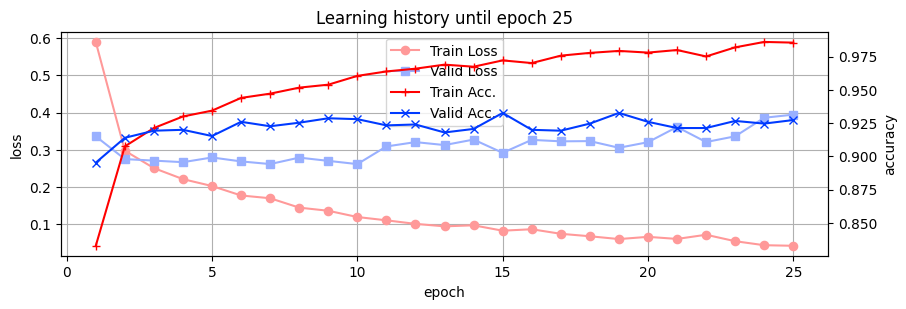

Iter:   25 >> T_loss 0.04239    T_acc 0.98545   V_loss 0.39449    V_acc 0.92724   🕒 11.462s
Iter:   24 >> T_loss 0.04392    T_acc 0.98597   V_loss 0.38614    V_acc 0.92457   🕒 11.451s
Iter:   23 >> T_loss 0.05468    T_acc 0.98189   V_loss 0.33629    V_acc 0.92657   🕒 11.496s
Iter:   22 >> T_loss 0.07200    T_acc 0.97506   V_loss 0.32094    V_acc 0.92123   🕒 11.517s
Iter:   21 >> T_loss 0.06078    T_acc 0.97988   V_loss 0.36129    V_acc 0.92123   🕒 11.499s
Iter:   20 >> T_loss 0.06639    T_acc 0.97795   V_loss 0.32051    V_acc 0.92590   🕒 11.545s
Iter:   19 >> T_loss 0.06041    T_acc 0.97922   V_loss 0.30555    V_acc 0.93258   🕒 11.430s
Iter:   18 >> T_loss 0.06797    T_acc 0.97773   V_loss 0.32342    V_acc 0.92457   🕒 11.480s
Iter:   17 >> T_loss 0.07456    T_acc 0.97565   V_loss 0.32283    V_acc 0.91923   🕒 11.475s
Iter:   16 >> T_loss 0.08679    T_acc 0.97009   V_loss 0.32679    V_acc 0.91989   🕒 11.514s
Iter:   15 >> T_loss 0.08290    T_acc 0.97209   V_loss 0.29199    V_acc 0.93258 

In [47]:
# Training Initialization
# init_model(MyModel(len(train_0_x.view([-1])), 10))
init_model(MyModel())
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

In [ ]:
|

## CNN 2

In [48]:
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.bn2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        t = t.view(t.shape[0], 1, 28, 28).type('torch.FloatTensor').cuda()

        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        t = self.bn1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        
        # flatten
        t = t.reshape(-1, 12*4*4)
        t = self.dropout(t)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.bn2(t)
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        
        return t

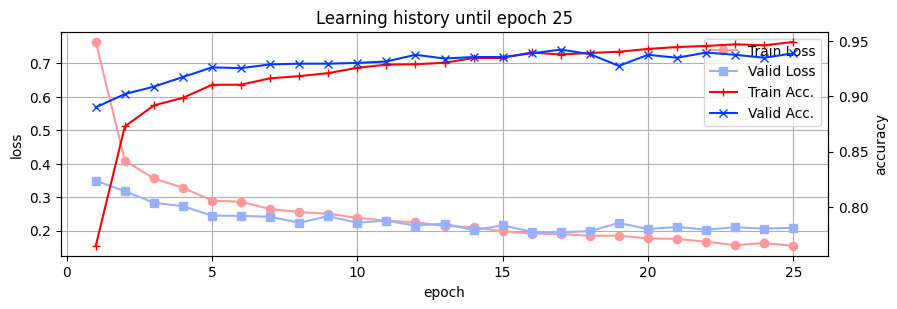

Iter:   25 >> T_loss 0.15443    T_acc 0.94886   V_loss 0.20835    V_acc 0.93858   🕒 11.455s
Iter:   24 >> T_loss 0.16273    T_acc 0.94581   V_loss 0.20579    V_acc 0.93458   🕒 11.507s
Iter:   23 >> T_loss 0.15641    T_acc 0.94670   V_loss 0.20986    V_acc 0.93725   🕒 11.482s
Iter:   22 >> T_loss 0.16656    T_acc 0.94522   V_loss 0.20256    V_acc 0.93925   🕒 11.477s
Iter:   21 >> T_loss 0.17488    T_acc 0.94425   V_loss 0.21092    V_acc 0.93458   🕒 11.443s
Iter:   20 >> T_loss 0.17651    T_acc 0.94255   V_loss 0.20455    V_acc 0.93725   🕒 11.450s
Iter:   19 >> T_loss 0.18479    T_acc 0.94002   V_loss 0.22285    V_acc 0.92724   🕒 11.567s
Iter:   18 >> T_loss 0.18424    T_acc 0.93891   V_loss 0.19809    V_acc 0.93792   🕒 11.495s
Iter:   17 >> T_loss 0.18936    T_acc 0.93750   V_loss 0.19470    V_acc 0.94192   🕒 11.549s
Iter:   16 >> T_loss 0.19115    T_acc 0.93936   V_loss 0.19610    V_acc 0.93858   🕒 11.406s
Iter:   15 >> T_loss 0.19788    T_acc 0.93438   V_loss 0.21574    V_acc 0.93525 

In [49]:
# Training Initialization
init_model(MyModel2())
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## CNN3 - elu + fc 3

In [31]:
class MyModel3(nn.Module):
    def __init__(self):
        super(MyModel3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(5,5))
        
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=24*4*4, out_features=256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        t = t.view(t.shape[0], 1, 28, 28).type('torch.FloatTensor').cuda()

        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        t = self.bn1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        
        # flatten
        t = t.reshape(-1, 24*4*4)
        t = self.dropout(t)

        t = self.fc1(t)
        t = F.elu(t)
        t = self.bn2(t)
        t = self.dropout(t)

        t = self.fc2(t)
        t = F.elu(t)
        t = self.bn3(t)
        t = self.dropout(t)

        t = self.fc3(t)
        t = F.elu(t)
        t = self.bn4(t)

        # output
        t = self.out(t)
        
        return t

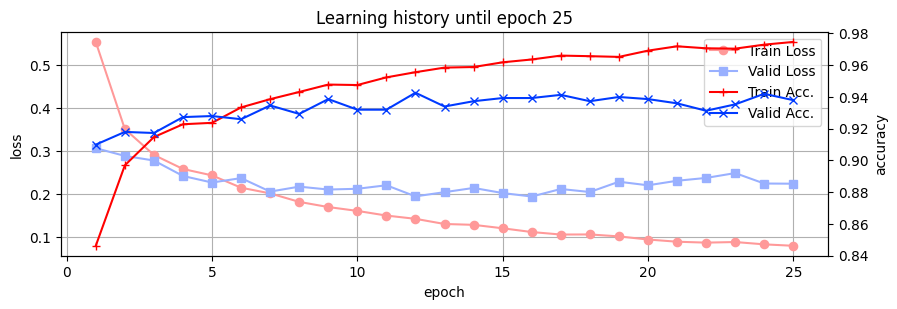

Iter:   25 >> T_loss 0.07936    T_acc 0.97461   V_loss 0.22353    V_acc 0.93792   🕒 8.246s
Iter:   24 >> T_loss 0.08267    T_acc 0.97291   V_loss 0.22395    V_acc 0.94192   🕒 8.126s
Iter:   23 >> T_loss 0.08808    T_acc 0.97038   V_loss 0.24819    V_acc 0.93525   🕒 8.050s
Iter:   22 >> T_loss 0.08667    T_acc 0.97061   V_loss 0.23692    V_acc 0.93124   🕒 8.185s
Iter:   21 >> T_loss 0.08880    T_acc 0.97187   V_loss 0.23036    V_acc 0.93591   🕒 8.098s
Iter:   20 >> T_loss 0.09393    T_acc 0.96912   V_loss 0.21981    V_acc 0.93858   🕒 8.182s
Iter:   19 >> T_loss 0.10114    T_acc 0.96519   V_loss 0.22810    V_acc 0.93992   🕒 8.179s
Iter:   18 >> T_loss 0.10568    T_acc 0.96563   V_loss 0.20422    V_acc 0.93725   🕒 8.233s
Iter:   17 >> T_loss 0.10548    T_acc 0.96600   V_loss 0.21121    V_acc 0.94126   🕒 8.231s
Iter:   16 >> T_loss 0.11128    T_acc 0.96355   V_loss 0.19373    V_acc 0.93925   🕒 8.195s
Iter:   15 >> T_loss 0.12001    T_acc 0.96177   V_loss 0.20181    V_acc 0.93925   🕒 8.165s

In [32]:
# Training Initialization
init_model(MyModel3())
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## CNN 4 - currently best score (epoch 25, adam)

In [65]:
class MyModel4(nn.Module):
    def __init__(self):
        super(MyModel4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(5,5))
        
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=24*4*4, out_features=128)
        self.bn2 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        t = t.view(t.shape[0], 1, 28, 28).type('torch.FloatTensor').cuda()

        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        t = self.bn1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        
        # flatten
        t = t.reshape(-1, 24*4*4)
        t = self.dropout(t)

        t = self.fc1(t)
        t = F.elu(t)
        t = self.bn2(t)
        t = self.dropout(t)

        t = self.fc2(t)
        t = F.elu(t)
        t = self.bn3(t)
        t = self.dropout(t)
        
        # output
        t = self.out(t)
        
        return t

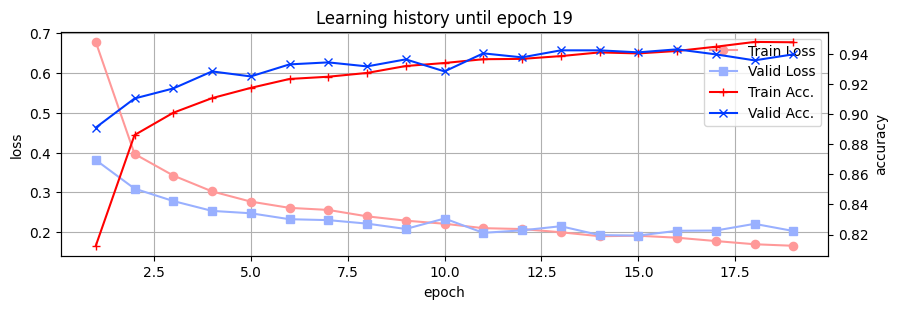

Iter:   19 >> T_loss 0.16556    T_acc 0.94797   V_loss 0.20279    V_acc 0.93992   🕒 7.987s
Iter:   18 >> T_loss 0.16943    T_acc 0.94819   V_loss 0.22074    V_acc 0.93591   🕒 7.966s
Iter:   17 >> T_loss 0.17749    T_acc 0.94500   V_loss 0.20394    V_acc 0.93992   🕒 7.922s
Iter:   16 >> T_loss 0.18587    T_acc 0.94218   V_loss 0.20329    V_acc 0.94326   🕒 7.959s
Iter:   15 >> T_loss 0.19084    T_acc 0.94054   V_loss 0.19126    V_acc 0.94126   🕒 7.956s
Iter:   14 >> T_loss 0.18965    T_acc 0.94121   V_loss 0.19244    V_acc 0.94259   🕒 7.964s
Iter:   13 >> T_loss 0.19959    T_acc 0.93876   V_loss 0.21478    V_acc 0.94259   🕒 8.067s
Iter:   12 >> T_loss 0.20768    T_acc 0.93691   V_loss 0.20437    V_acc 0.93792   🕒 8.018s
Iter:   11 >> T_loss 0.20989    T_acc 0.93668   V_loss 0.19812    V_acc 0.94059   🕒 7.940s
Iter:   10 >> T_loss 0.22099    T_acc 0.93416   V_loss 0.23417    V_acc 0.92857   🕒 7.960s
Iter:    9 >> T_loss 0.22878    T_acc 0.93216   V_loss 0.20784    V_acc 0.93658   🕒 7.948s

In [ ]:
# Training Initialization
init_model(MyModel4())
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## CNN 5 - 여기까지 제출 완료

In [61]:
class MyModel5(nn.Module):
    def __init__(self):
        super(MyModel5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3,3))
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(4,4))
        
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=12*5*5, out_features=128)
        self.bn2 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        t = t.view(t.shape[0], 1, 28, 28).type('torch.FloatTensor').cuda()

        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        t = self.bn1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        
        # flatten
        t = t.reshape(-1, 12*5*5)
        t = self.dropout(t)

        t = self.fc1(t)
        t = F.elu(t)
        t = self.bn2(t)
        t = self.dropout(t)

        t = self.fc2(t)
        t = F.elu(t)
        t = self.bn3(t)
        t = self.dropout(t)
        
        # output
        t = self.out(t)
        
        return t

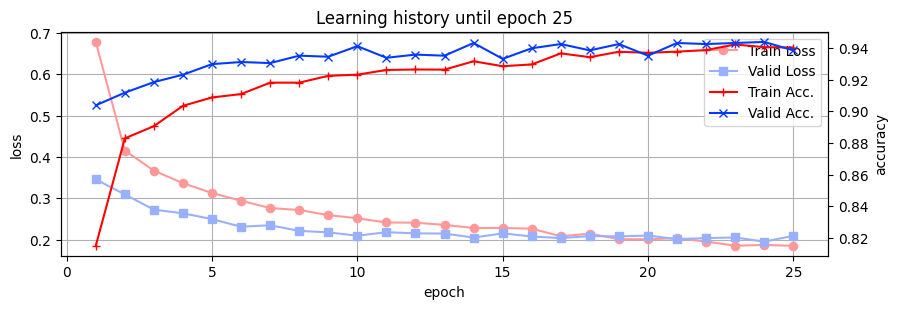

Iter:   25 >> T_loss 0.18515    T_acc 0.94039   V_loss 0.20914    V_acc 0.93858   🕒 7.993s
Iter:   24 >> T_loss 0.18721    T_acc 0.94062   V_loss 0.19519    V_acc 0.94393   🕒 7.991s
Iter:   23 >> T_loss 0.18527    T_acc 0.94232   V_loss 0.20523    V_acc 0.94326   🕒 7.967s
Iter:   22 >> T_loss 0.19547    T_acc 0.93876   V_loss 0.20390    V_acc 0.94259   🕒 7.994s
Iter:   21 >> T_loss 0.20352    T_acc 0.93780   V_loss 0.20113    V_acc 0.94326   🕒 8.046s
Iter:   20 >> T_loss 0.20097    T_acc 0.93705   V_loss 0.21000    V_acc 0.93525   🕒 8.108s
Iter:   19 >> T_loss 0.20122    T_acc 0.93772   V_loss 0.20778    V_acc 0.94259   🕒 8.027s
Iter:   18 >> T_loss 0.21440    T_acc 0.93431   V_loss 0.20858    V_acc 0.93858   🕒 8.030s
Iter:   17 >> T_loss 0.20829    T_acc 0.93668   V_loss 0.20381    V_acc 0.94259   🕒 7.996s
Iter:   16 >> T_loss 0.22648    T_acc 0.92971   V_loss 0.20762    V_acc 0.93992   🕒 8.009s
Iter:   15 >> T_loss 0.22829    T_acc 0.92859   V_loss 0.21515    V_acc 0.93324   🕒 8.000s

In [62]:
# Training Initialization
init_model(MyModel5())
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## CNN 6

In [ ]:
class MyModel5(nn.Module):
    def __init__(self):
        super(MyModel5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3,3))
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(4,4))
        
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=12*5*5, out_features=128)
        self.bn2 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, t): # implements the forward method (flow of tensors)
        t = t.view(t.shape[0], 1, 28, 28).type('torch.FloatTensor').cuda()

        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        t = self.bn1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.elu(t)
        
        # flatten
        t = t.reshape(-1, 12*5*5)
        t = self.dropout(t)

        t = self.fc1(t)
        t = F.elu(t)
        t = self.bn2(t)
        t = self.dropout(t)

        t = self.fc2(t)
        t = F.elu(t)
        t = self.bn3(t)
        t = self.dropout(t)
        
        # output
        t = self.out(t)
        
        return t

In [54]:
import os

In [ ]:
# save and load
torch.save(net, './model.pkl')
net_test = torch.load('./model.pkl')

In [63]:
# Save prediction vector to CSV file

# Before run this code, here put your save path (only for local server not kaggle kernel)
save_root = './submission3.csv'   # <--- only edit this path

# After run this code, you must check that the shape of 'out' variable is 3745.
# out.shape == torch.Size([3745])


# ============================== Do not edit under this line ============================ 
for _data in test_loader:
    data = _data.view([len(_data), -1]).to(device)

    # 1. Feed-forward
    onehot_out = net(data)
    _, out = torch.max(onehot_out, 1)
    
assert out.shape == torch.Size([3745]), 'Shape of out must torch.Size([3745])'

import csv

# 덮어쓰기 방지를 위해 이미 파일이 존재하면 삭제
if os.path.isfile(save_root):
    os.remove(save_root)

# 첫 행에 'id' 'lable' 그 다음 행부터 idx와 label 넣어서 csv 저장
for idx, pred in enumerate(list(out.cpu())):
    with open(save_root, 'a', newline='') as f:
        writer = csv.writer(f)
        if idx == 0:
            writer.writerow(['Id', 'Category'])
        pred = np.concatenate(([idx], [pred]))
        writer.writerow(pred)
# ============================== Do not edit under this line ============================